# 1. Preliminary

## 1.1 Context

## 1.2 Imports

In [1]:
# builtin
import os, sys, time, random


# data
import pandas as pd
import numpy as np


# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import spacy


# ML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD , PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit


# viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px
from wordcloud import WordCloud
from PIL import Image


# parallelisation
from pandarallel import pandarallel

## 1.3 downloads and options

In [2]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package omw-1.4 to /home/alex/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /home/alex/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
# init sns

sns.set()

In [4]:
# init pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 1.4 Loading data

In [5]:
# our file

data = "./data/cleaned/"
os.listdir(data)

['df.csv',
 'final_df.csv',
 'unique_words.csv',
 'finad_df.csv',
 'min_5_words.csv']

In [6]:
# load dataframe

fn = data + 'final_df.csv'
df = pd.read_csv(fn)

In [7]:
df.head(2)

,text,target,_len_txt,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,reason earthquak may allah
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near canada


In [12]:
df

,text,target,_len_txt,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,reason earthquak may allah
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near canada
2,All residents asked to 'shelter in place' are ...,1,133,resid ask shelter place offic evacu shelter pl...
3,"13,000 people receive #wildfires evacuation or...",1,65,peopl wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo alaska smoke wildfir school
...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,83,two giant crane hold bridg collaps nearbi home
7609,@aria_ahrary @TheTawniest The out of control w...,1,125,control wild fire california even northern par...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,volcano
7611,Police investigating after an e-bike collided ...,1,137,polic investig bike collid car littl bike seri...


In [8]:
df.isna().sum()

text           0
target         0
_len_txt       0
clean_text    53
dtype: int64

In [11]:
df =df.dropna()
df

,text,target,_len_txt,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,reason earthquak may allah
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near canada
2,All residents asked to 'shelter in place' are ...,1,133,resid ask shelter place offic evacu shelter pl...
3,"13,000 people receive #wildfires evacuation or...",1,65,peopl wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo alaska smoke wildfir school
...,...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,1,83,two giant crane hold bridg collaps nearbi home
7609,@aria_ahrary @TheTawniest The out of control w...,1,125,control wild fire california even northern par...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,volcano
7611,Police investigating after an e-bike collided ...,1,137,polic investig bike collid car littl bike seri...


# 2. Modelisation

## Tf Idf

In [13]:
tf = TfidfVectorizer()
X = tf.fit_transform(df.clean_text)
X

<7560x1692 sparse matrix of type '<class 'numpy.float64'>'
	with 40054 stored elements in Compressed Sparse Row format>

In [14]:
X = pd.DataFrame(X.toarray(), columns=tf.get_feature_names_out())
X

,aba,abandon,abl,ablaz,absolut,absurdli,access,accid,accident,accord,...,yesterday,yet,york,young,youth,yr,zeal,zodiac,zombi,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## pca

In [15]:
pca = PCA()
X_pca = pca.fit_transform(X)

In [16]:
pca.explained_variance_ratio_

array([6.29866954e-03, 5.98517622e-03, 5.74878266e-03, ...,
       8.13508938e-35, 3.92724435e-35, 4.22274958e-36])

In [17]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [18]:
len(cumsum)

1692

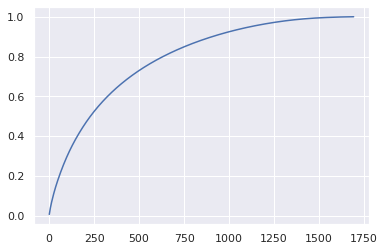

In [19]:
plt.plot(range(1, len(cumsum)+1), cumsum)

In [20]:
X_pca = X_pca[:, :500]

In [21]:
X_pca.shape

(7560, 500)

In [22]:
X_train = pd.DataFrame(X_pca)
y_train = df.target

In [23]:
estimator = RandomForestClassifier()
param_grid = {}
cv = 5

In [24]:
grid = GridSearchCV(estimator, param_grid, cv=cv, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1, param_grid={},
             return_train_score=True)

In [25]:
res = pd.DataFrame(grid.cv_results_)
cols = [i for i in res.columns if "split" not in i ]
res = res[cols]
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,16.803396,1.795503,0.056708,0.010237,{},0.674603,0.031979,1,0.975761,0.001325


In [26]:
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,16.803396,1.795503,0.056708,0.010237,{},0.674603,0.031979,1,0.975761,0.001325


## TSVD

In [27]:
tsd = TruncatedSVD(n_components=30)
X_tsd = tsd.fit_transform(X)

In [28]:
grid = GridSearchCV(estimator, param_grid, cv=cv, n_jobs=-1, return_train_score=True)
grid.fit(X_tsd, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1, param_grid={},
             return_train_score=True)

In [29]:
res = pd.DataFrame(grid.cv_results_)
cols = [i for i in res.columns if "split" not in i ]
res = res[cols]
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,2.748391,0.275747,0.028671,0.002351,{},0.679894,0.042772,1,0.975761,0.001325


In [30]:
pipe = Pipeline([
    ("reduction", TruncatedSVD()), 
    ("estimator", RandomForestClassifier()),
     ])

In [31]:
scaler_list = [StandardScaler()]

In [38]:
n_components = np.linspace(2, 100, 20).astype(int)
n_components

array([  2,   7,  12,  17,  22,  27,  32,  38,  43,  48,  53,  58,  63,
        69,  74,  79,  84,  89,  94, 100])

In [39]:
param_grid = { "reduction" : [TruncatedSVD()], 
               "estimator" : [RandomForestClassifier()], 
               "reduction__n_components": n_components
             }

In [40]:
X.shape

(7560, 1692)

In [41]:
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

In [42]:
grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, return_train_score=True, verbose=3)
grid.fit(X, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('reduction', TruncatedSVD()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'estimator': [RandomForestClassifier()],
                         'reduction': [TruncatedSVD(n_components=79)],
                         'reduction__n_components': array([  2,   7,  12,  17,  22,  27,  32,  38,  43,  48,  53,  58,  63,
        69,  74,  79,  84,  89,  94, 100])},
             return_train_score=True, verbose=3)

In [43]:
res = pd.DataFrame(grid.cv_results_)
cols = [i for i in res.columns if "split" not in i ]
res = res[cols]
res.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_reduction,param_reduction__n_components,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
15,12.503088,0.419807,0.182917,0.013908,RandomForestClassifier(),TruncatedSVD(n_components=79),79,"{'estimator': RandomForestClassifier(), 'reduc...",0.764127,0.010515,1,0.977460,0.000860
12,10.265895,0.162777,0.163709,0.010554,RandomForestClassifier(),TruncatedSVD(n_components=79),63,"{'estimator': RandomForestClassifier(), 'reduc...",0.763069,0.009561,2,0.977354,0.000761
17,14.801270,0.510084,0.185507,0.017606,RandomForestClassifier(),TruncatedSVD(n_components=79),89,"{'estimator': RandomForestClassifier(), 'reduc...",0.762857,0.005513,3,0.977531,0.000847
10,11.321980,0.268262,0.158862,0.003828,RandomForestClassifier(),TruncatedSVD(n_components=79),53,"{'estimator': RandomForestClassifier(), 'reduc...",0.762646,0.006520,4,0.977354,0.000761
18,14.847220,0.472607,0.178785,0.037052,RandomForestClassifier(),TruncatedSVD(n_components=79),94,"{'estimator': RandomForestClassifier(), 'reduc...",0.762116,0.008908,5,0.977531,0.000910
19,12.090955,1.729985,0.089365,0.015585,RandomForestClassifier(),TruncatedSVD(n_components=79),100,"{'estimator': RandomForestClassifier(), 'reduc...",0.761799,0.007699,6,0.977531,0.000847
11,10.511729,0.172812,0.150514,0.005265,RandomForestClassifier(),TruncatedSVD(n_components=79),58,"{'estimator': RandomForestClassifier(), 'reduc...",0.761481,0.006796,7,0.977354,0.000761
14,11.529017,0.166881,0.173759,0.019454,RandomForestClassifier(),TruncatedSVD(n_components=79),74,"{'estimator': RandomForestClassifier(), 'reduc...",0.761058,0.009615,8,0.977460,0.000760
8,9.044214,0.200538,0.181181,0.038246,RandomForestClassifier(),TruncatedSVD(n_components=79),43,"{'estimator': RandomForestClassifier(), 'reduc...",0.760000,0.005212,9,0.977319,0.000817
16,15.168059,0.421404,0.200585,0.046859,RandomForestClassifier(),TruncatedSVD(n_components=79),84,"{'estimator': RandomForestClassifier(), 'reduc...",0.759683,0.011025,10,0.977496,0.000793


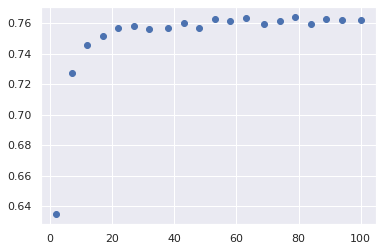

In [44]:
plt.scatter(res.param_reduction__n_components, res.mean_test_score)

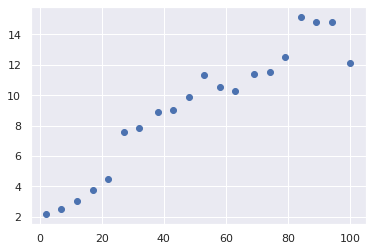

[CV 5/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=2;, score=(train=0.978, test=0.639) total time=   2.3s
[CV 2/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=12;, score=(train=0.977, test=0.732) total time=   3.1s
[CV 5/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=17;, score=(train=0.978, test=0.758) total time=   3.8s
[CV 2/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=27;, score=(train=0.977, test=0.748) total time=   7.6s
[CV 1/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=38;, score=(train=0.978, test=0.768) total time=   8.9s
[CV 4/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=43;, score=(train=0.978, test=0.761) total time=   9.0s
[CV 2/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD

[CV 3/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=2;, score=(train=0.976, test=0.625) total time=   2.3s
[CV 1/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=12;, score=(train=0.978, test=0.756) total time=   3.1s
[CV 4/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=17;, score=(train=0.978, test=0.759) total time=   3.9s
[CV 3/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=27;, score=(train=0.976, test=0.764) total time=   7.4s
[CV 5/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=32;, score=(train=0.978, test=0.755) total time=   8.1s
[CV 3/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD(), reduction__n_components=43;, score=(train=0.976, test=0.762) total time=   9.1s
[CV 1/5] END estimator=RandomForestClassifier(), reduction=TruncatedSVD

In [45]:
plt.scatter(res.param_reduction__n_components, res.mean_fit_time)